# Определение возраста покупателей

## Исследовательский анализ данных

In [1]:
import pandas as pd
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from matplotlib import pyplot as plt
import seaborn as sns
from tqdm.notebook import tqdm_notebook as tqdm
from PIL import Image
import numpy as np

In [2]:
img_path = '/datasets/faces/final_files/'

Изучим датасет.

Построим график распределения возраста в выборке.  
Посмотрим на неколько случайно взятых изображений.

In [3]:
labels = pd.read_csv('/datasets/faces/labels.csv')
train_datagen = ImageDataGenerator(rescale=1./255)
train_it = train_datagen.flow_from_dataframe(
      dataframe=labels,
      directory=img_path,
      x_col='file_name',
      y_col='real_age',
      target_size=(224, 224),
      batch_size=32,
      class_mode='raw',
      seed=12345)

Found 7591 validated image filenames.


Видим количество найденных изображений

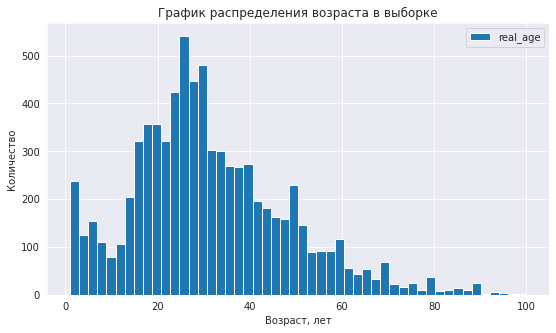

In [4]:
sns.set_style("dark")
labels.plot(kind='hist',figsize=(9,5),bins=50, grid=True)
plt.title('График распределения возраста в выборке')
plt.xlabel('Возраст, лет')
plt.ylabel('Количество')
plt.show()

Количество изображений и меток совпадает.

В основном значения возраста распредлены нормально.
Максимум приходится на значение возраста около 27, однако также имеется небольшой максимум в значениях около нуля, что может сказать о том, что возраст неизвестен.  
Позле значения 20 выбиваются частоты значений возраста, кратные 10, возможно это свзяано с округлениями значений возраста до 10 лет в случае, если возраст человека на фото не был известен точно.

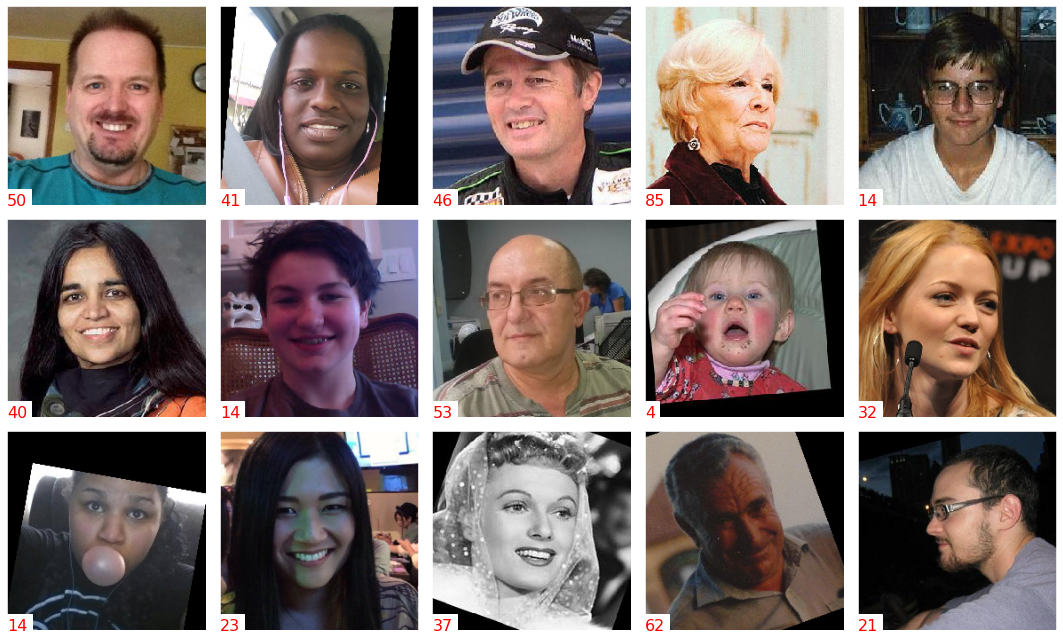

In [5]:
x, y = next(train_it)
fig = plt.figure(figsize=(15,9))
for i in range(15):
    ax = fig.add_subplot(3, 5, i+1)
    plt.imshow(x[i])
    plt.text(0, 0, y[i], fontsize = 16, transform=ax.transAxes,
             color='red', backgroundcolor='white')
    plt.xticks([])
    plt.yticks([])
    plt.tight_layout()

Попавшие в вывод изображения - квадратные. На всех изображены только лица людей, расположенные в центре. Таким образом работаем с фотографиями, полученными уже после детекции.

Посмотрим на размеры изображений


In [6]:
img_sizes = labels.copy().set_index('file_name')
for file_name in tqdm(labels.file_name):
    img = Image.open(img_path+file_name)
    img_sizes.loc[file_name, ['h','w']] = img.size

img_sizes.sample(10)

  0%|          | 0/7591 [00:00<?, ?it/s]

,real_age,h,w
file_name,,,
006120.jpg,45,178.0,178.0
006650.jpg,30,119.0,120.0
001218.jpg,30,202.0,201.0
001913.jpg,24,689.0,689.0
005108.jpg,32,434.0,434.0
007386.jpg,50,111.0,111.0
005167.jpg,38,239.0,239.0
003586.jpg,70,379.0,379.0
005397.jpg,19,131.0,131.0


Изображения имеют разное разрешение. Это не проблема, поскольку метод-итератор класса ImageDataGenerator приведёт их к одинаковому. Мы будем использовать размер (224, 224), который задан по умолчанию для модели ResNet50

Посмотрим, сколько изображений имеют неравное соотношение сторон


In [7]:
img_sizes['is_square'] = (img_sizes.h - img_sizes.w) <= 1
(~img_sizes.is_square).sum()

117

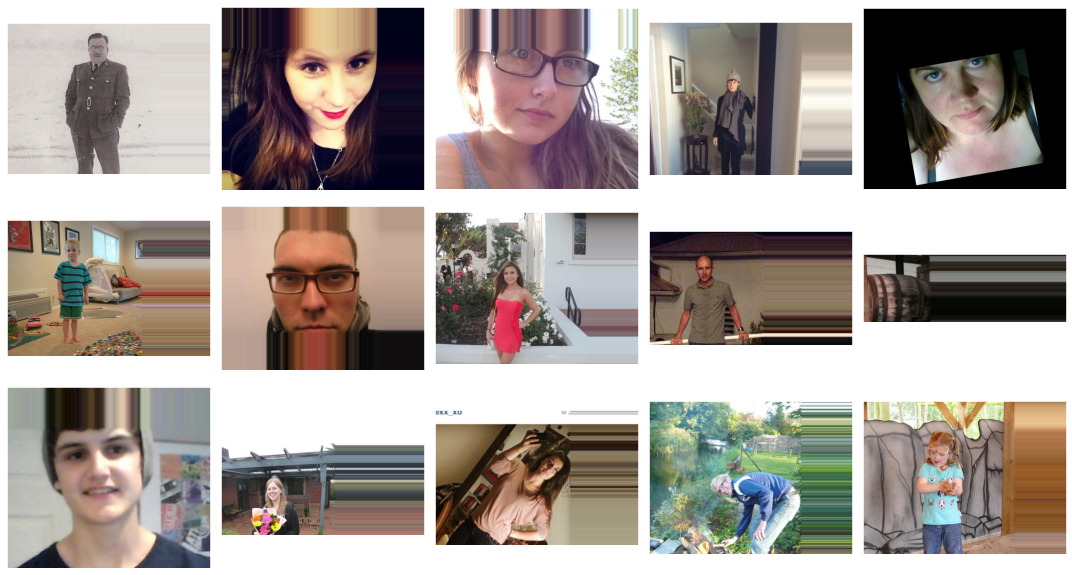

In [8]:
fig = plt.figure(figsize=(15,9))
i = 0
for file_name in img_sizes[~img_sizes.is_square].sample(15).index:
    i += 1
    fig.add_subplot(3, 5, i)
    plt.imshow(Image.open(img_path+file_name))
    plt.xticks([])
    plt.yticks([])
    plt.tight_layout()

Выявили наличие проблем в датасете. А именно, некторые фотографии

не квадратные

Наличие таких фотографий может быть связано с ошибками в процессе сохранения изображений. При загрузке таких изображений метод-итератор класса ImageDataGenerator приведёт их к квадратным, тем самым исказив. Однако доля таких изображений невилика.

Также имеются изображения с:

не портретными фотографиями - люди во весь рост, сразу несколько человек и т.п.
не содержат лиц или людей вовсе.

Это вероятнее всего связано с ошибками работы алгоритма детекции.

Наличие таких проблемных изображений в обучающей выборке приведёт к тому, что обученная модель будет склонна ошибаться.


## Обучение модели

Перенесите сюда код обучения модели и её результат вывода на экран.


(Код в этом разделе запускается в отдельном GPU-тренажёре, поэтому оформлен не как ячейка с кодом, а как код в текстовой ячейке)

```python

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications.resnet import ResNet50
from tensorflow import keras
import pandas as pd 


def load_train(path):
    """ Loading of train dataset from 'final_files/' subfolder in `path`
    """
    labels = pd.read_csv(path + 'labels.csv')

    datagen = ImageDataGenerator(
        validation_split=0.25,
        rescale=1/255.,
        horizontal_flip=True,
        width_shift_range=0.15,
        height_shift_range=0.15,
        zoom_range=0.1,
    )

    return datagen.flow_from_dataframe(
        dataframe = labels,
        directory = path+'final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=32,
        class_mode='raw',
        subset='training',
        seed=123,
    )


def load_test(path):
    """ Loading of test dataset from 'final_files/' subfolder in `path`
    """
    labels = pd.read_csv(path + 'labels.csv')

    datagen = ImageDataGenerator(
        validation_split=0.25,
        rescale=1/255.)

    return datagen.flow_from_dataframe(
        dataframe=labels,
        directory=path+'final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=32,
        class_mode='raw',
        subset='validation',
        seed=123,
    )


def create_model(input_shape):
    """ Creating of ResNet50 model for objects with shape = `input_shape`.  
        Custom fully-connected layer at the top of the network with `relu` activation for predict age value
    """
    backbone = ResNet50(
        weights='/datasets/keras_models/resnet50_weights_tf_dim_ordering_tf_kernels_notop.h5',
        input_shape=input_shape, 
        include_top=False)
    
    model = Sequential()
    model.add(backbone)
    model.add(GlobalAveragePooling2D())
    model.add(Dense(1, activation='relu'))
    model.compile(optimizer=Adam(learning_rate=0.0005), 
                  loss='mean_squared_error', metrics=['mean_absolute_error'])
    return model


def train_model(model, train_data, test_data, batch_size=None, epochs=20,
                steps_per_epoch=None, validation_steps=None):
    """ Training of `model`
    
    ----
    `train_data` : DataFrameIterator for training dataset
    `test_data` : DataFrameIterator for validation dataset
    `epochs`, `batch_size` : params of keras.Model.fit()
    """
    model.fit(train_data,
        validation_data=test_data,
        epochs=epochs, batch_size=batch_size,
        steps_per_epoch=steps_per_epoch, #train_data.samples/train_data.batch_size,
        validation_steps=validation_steps, #test_data.samples/test_data.batch_size,
        verbose=2, shuffle=True)
    return model

```

```

<class 'tensorflow.python.keras.engine.sequential.Sequential'>

WARNING:tensorflow:sample_weight modes were coerced from

  ...

    to  

  ['...']

WARNING:tensorflow:sample_weight modes were coerced from

  ...

    to  

  ['...']

Train for 178 steps, validate for 60 steps

Epoch 1/20

2023-07-20 20:42:50.624134: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcublas.so.10

2023-07-20 20:42:51.074554: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudnn.so.7

178/178 - 105s - loss: 233.6458 - mean_absolute_error: 11.4222 - val_loss: 531.3155 - val_mean_absolute_error: 17.8161

Epoch 2/20

178/178 - 98s - loss: 132.4861 - mean_absolute_error: 8.7764 - val_loss: 418.1523 - val_mean_absolute_error: 15.2734

Epoch 3/20

178/178 - 98s - loss: 111.9257 - mean_absolute_error: 8.0250 - val_loss: 289.9783 - val_mean_absolute_error: 12.7856

Epoch 4/20

178/178 - 97s - loss: 104.1553 - mean_absolute_error: 7.7866 - val_loss: 268.8587 - val_mean_absolute_error: 12.3744

Epoch 5/20

178/178 - 92s - loss: 95.3151 - mean_absolute_error: 7.3720 - val_loss: 112.5337 - val_mean_absolute_error: 8.4293

Epoch 6/20

178/178 - 92s - loss: 84.2320 - mean_absolute_error: 6.9386 - val_loss: 110.7878 - val_mean_absolute_error: 8.1119

Epoch 7/20

178/178 - 92s - loss: 75.5312 - mean_absolute_error: 6.6291 - val_loss: 166.6288 - val_mean_absolute_error: 9.4401

Epoch 8/20

178/178 - 93s - loss: 71.2603 - mean_absolute_error: 6.4580 - val_loss: 111.6507 - val_mean_absolute_error: 8.6055

Epoch 9/20

178/178 - 92s - loss: 68.1626 - mean_absolute_error: 6.2389 - val_loss: 113.3043 - val_mean_absolute_error: 7.9096

Epoch 10/20

178/178 - 92s - loss: 66.5705 - mean_absolute_error: 6.1831 - val_loss: 139.2407 - val_mean_absolute_error: 8.8629

Epoch 11/20

178/178 - 87s - loss: 61.5779 - mean_absolute_error: 5.9405 - val_loss: 125.2485 - val_mean_absolute_error: 7.8970

Epoch 12/20

178/178 - 87s - loss: 60.3865 - mean_absolute_error: 5.9382 - val_loss: 93.4394 - val_mean_absolute_error: 7.3062

Epoch 13/20

178/178 - 88s - loss: 62.4553 - mean_absolute_error: 5.9934 - val_loss: 237.3327 - val_mean_absolute_error: 11.7254

Epoch 14/20

178/178 - 88s - loss: 53.8170 - mean_absolute_error: 5.5984 - val_loss: 111.9364 - val_mean_absolute_error: 8.3016

Epoch 15/20

178/178 - 88s - loss: 51.0890 - mean_absolute_error: 5.4635 - val_loss: 105.6790 - val_mean_absolute_error: 7.6058

Epoch 16/20

178/178 - 87s - loss: 48.6079 - mean_absolute_error: 5.3040 - val_loss: 82.6289 - val_mean_absolute_error: 6.8836

Epoch 17/20

178/178 - 87s - loss: 50.9479 - mean_absolute_error: 5.4266 - val_loss: 156.8132 - val_mean_absolute_error: 9.5103

Epoch 18/20

178/178 - 88s - loss: 44.6612 - mean_absolute_error: 5.1132 - val_loss: 81.7320 - val_mean_absolute_error: 6.6663

Epoch 19/20

178/178 - 87s - loss: 40.8774 - mean_absolute_error: 4.9215 - val_loss: 120.6713 - val_mean_absolute_error: 8.0682

Epoch 20/20

178/178 - 87s - loss: 38.4491 - mean_absolute_error: 4.8038 - val_loss: 84.2035 - val_mean_absolute_error: 6.904

```

<div class="alert alert-success">
<font size="4"><b>✔️ Комментарий ревьюера</b></font>
    <br /> 
    <font size="3", color = "black">
<br />
Необходимая метрика достигнута

## Анализ обученной модели



Перед нами стояла задача построить и обучить модель, которая поможет определять возраст человека по изображению с камеры со средним абсолютным отклонением MAE не выше 7.

    В нашем распоряжении был датасет с 7591 размеченной фотографией, среди которых преимущественно были фотографии выполненные при слабом освещении и с вращением по горизонтальной оси. Для того, чтобы модель обучилась точнее мы предварительно отделив % данных для тренировки модели, использовали специальные гиперпараметры, которые добавили в тренировочную выборку фотографии с похожими эффектами, а оставшиеся % оставили без изменений для тестирования модели.

    В качестве основы за модель взяли уже предобученную нейросеть с архитектурой ResNet50 и дополнительно обучили её на наших данных без замораживания. В выходном слое,для более точного обучения модели, использовали оптимизацию Adam c шагом обучения 0.0005, а в качестве функции потерь использовалась mean_squared_error (mse).

С такими параметрами мы протестировали нашу модель на 20 эпохах и  она достигла значения по метрике MAE равное 6.904, что уже меньше 7. Таким образом мы достигли требуемой точности предсказания возраста нашей моделью и смело можем рекомендовать её к использованию.  

Для повышения качества предсказания возможно было бы целесообразно расширить датасет в тех или иных возрастах.



## Чек-лист

- [x]  Jupyter Notebook открыт
- [x]  Весь код выполняется без ошибок
- [x]  Ячейки с кодом расположены в порядке исполнения
- [x]  Исследовательский анализ данных выполнен
- [x]  Результаты исследовательского анализа данных перенесены в финальную тетрадь
- [x]  MAE модели не больше 8
- [x]  Код обучения модели скопирован в финальную тетрадь
- [x]  Результат вывода модели на экран перенесён в финальную тетрадь
- [x]  По итогам обучения модели сделаны выводы